## LAB AGENTES - PARTE 1

## Dependencias

In [ ]:
%pip install \
    python-dotenv \
    langchain \
    langchain-chroma \
    langchain-google-genai \
    langchain-text-splitters \
    langchain-core \
    langgraph \
    langgraph-checkpoint-sqlite \
    ddgs

## Aplicación RAG basada en LangChain

In [2]:
from dotenv import load_dotenv
import os

# Cargar variables desde el archivo .env
load_dotenv()

# Asignar la clave de API a la variable de entorno que espera el SDK de Google
os.environ["GOOGLE_API_KEY"] = os.getenv("GOOGLE_API_KEY")

In [3]:
from langchain_text_splitters import MarkdownHeaderTextSplitter
from pathlib import Path

def load_and_chunk_markdown_documents(data_folder = "data"):

        """
    Carga todos los documentos Markdown desde la carpeta especificada,
    aplicando segmentación basada en estructura de encabezados para
    generar chunks semánticamente coherentes, listos para el proceso
    de embedding.

    Args:
        data_folder (str): Carpeta que contiene los archivos .md

    Returns:
        list: Lista de objetos Document (chunks) enriquecidos con metadatos
    """

        print("\nCARGA Y CHUNKING DE DOCUMENTOS EN FORMATO MARKDOWN")
        print("=" * 70)

        # Definir niveles jerárquicos que guiarán la segmentación
        headers_to_split_on = [
                ("#", "Header 1"),
                ("##", "Header 2"),
                ("###", "Header 3"),
                ("####", "Header 4"),
        ]

        # Segmentador basado en estructura de documento
        markdown_splitter = MarkdownHeaderTextSplitter(
                headers_to_split_on = headers_to_split_on,
                strip_headers = False
        )

        # Verificar existencia de la carpeta y archivos Markdown
        data_path = Path(data_folder)
        if not data_path.exists():
                raise FileNotFoundError(f"\nLa carpeta '{data_folder}' no existe")

        # Verificar que existan archivos a segmentar
        markdown_files = list(data_path.glob("*.md"))
        if not markdown_files:
                raise FileNotFoundError(f"\nNo se encontraron archivos .md en '{data_folder}'")

        all_chunks = []

        print(f"\nProcesando {len(markdown_files)} archivos:\n")
        print("-" * 30)

        for file_path in sorted(markdown_files):
                try:
                        # Leer contenido crudo del archivo
                        with open(file_path, 'r', encoding='utf-8') as file:
                                content = file.read()

                        # Aplicar segmentación estructural
                        chunks = markdown_splitter.split_text(content)

                        # Enriquecer cada chunk con metadatos útiles
                        for i, chunk in enumerate(chunks):
                                chunk.metadata.update({
                                        "source_file": file_path.name,
                                        "source_path": str(file_path),
                                        "chunk_index": i,
                                        "total_chunks_in_doc": len(chunks),
                                        "chunking_strategy": "document_structured",
                                        "file_size": file_path.stat().st_size,
                                        "chunk_size": len(chunk.page_content)
                                })

                        all_chunks.extend(chunks)
                        print(f"{file_path.name}: {len(chunks)} chunks generados")

                except Exception as e:
                        print(f"\nError procesando {file_path.name}: {str(e)}")
                        continue

        print("-" * 30)
        print(f"Total chunks generados: {len(all_chunks)}")

        # Mostrar estadísticas generales
        if all_chunks:
                chunk_sizes = [len(chunk.page_content) for chunk in all_chunks]
                print(f"Tamaño promedio de chunks: {sum(chunk_sizes) / len(chunk_sizes):.0f} caracteres")
                print(f"Rango de tamaños: {min(chunk_sizes)} - {max(chunk_sizes)} caracteres")
                print("-" * 30)

        return all_chunks

In [4]:
def prepare_documents_for_rag(data_folder = "data"):
    
        """
    Función completa que prepara documentos para el pipeline RAG.

    Returns:
        list: Chunks listos para crear embeddings y guardar en base de datos vectorial
    """

        # Cargar y hacer chunking de todos los documentos
        chunks = load_and_chunk_markdown_documents(data_folder)


        return chunks

In [5]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain_chroma import Chroma
import shutil

def load_to_chromadb(chunks, collection_name = "rag_docs", persist_directory = "./chroma_db"):
    
        """
    Función original mantenida para cargar documentos a ChromaDB.
    Esta función se usa antes de crear el grafo de LangGraph.
    """
       
        # Eliminar la base anterior si existe para asegurar una carga limpia
        if os.path.exists(persist_directory):
                shutil.rmtree(persist_directory)

        # Instanciar el modelo de embeddings de Google
        embeddings = GoogleGenerativeAIEmbeddings(model = "models/embedding-001")

        # Crear una base de datos vectorial persistente con la colección especificada
        vector_store = Chroma(
                collection_name = collection_name,
                embedding_function = embeddings,
                persist_directory = persist_directory
        )

        # Extraer los textos de cada chunk
        texts = [chunk.page_content for chunk in chunks]

        # Extraer los metadatos asociados
        metadatas = [chunk.metadata for chunk in chunks]

        # Generar identificadores únicos para cada chunk
        ids = [f"{chunk.metadata.get('source_file', 'doc')}_{i}" for i, chunk in enumerate(chunks)]

        # Agregar los embeddings y metadatos a la colección
        vector_store.add_texts(texts = texts, metadatas = metadatas, ids = ids)

        print(f"\nChromaDB: {len(chunks)} chunks cargados")
        return vector_store

In [6]:
# Generación de los chunks finales
final_chunks = prepare_documents_for_rag()
# Carga de los chunks a la base de datos vectorial
vector_store = load_to_chromadb(final_chunks)


CARGA Y CHUNKING DE DOCUMENTOS EN FORMATO MARKDOWN

Procesando 5 archivos:

------------------------------
api_development_standards.md: 20 chunks generados
development_policies.md: 28 chunks generados
multi_theme_descriptions.md: 7 chunks generados
software_architecture_guide.md: 14 chunks generados
troubleshooting_guide.md: 8 chunks generados
------------------------------
Total chunks generados: 77
Tamaño promedio de chunks: 413 caracteres
Rango de tamaños: 94 - 1692 caracteres
------------------------------


E0000 00:00:1763086931.991374   23594 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.



ChromaDB: 77 chunks cargados


In [7]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.prompts import ChatPromptTemplate

# Instancia del modelo a utilizar
llm = ChatGoogleGenerativeAI(
    model = "gemini-2.5-flash",
    temperature = 0.1,
    max_tokens = 200
)

# Promp base del asistente
prompt = ChatPromptTemplate.from_template("""
        Eres un asistente especializado en responder preguntas sobre documentación técnica de desarrollo de software. Utiliza únicamente la información del contexto proporcionado para
        responder la pregunta. Si no conoces la respuesta basándote en el contexto, indica claramente que no tienes esa información. Mantén las respuestas concisas, precisas y usa máximo
        tres oraciones.

        Pregunta: {question}

        Contexto: {context}

        Respuesta:
        """)

E0000 00:00:1763086934.164508   23594 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


## Asistente conversacional tipo ChatBot con LangGraph


In [8]:
from typing import TypedDict, List, Any, Dict
from langchain_core.documents import Document

class RAGState(TypedDict):
    
        """
    Estado centralizado para el sistema RAG con LangGraph.
    Reemplaza el manejo implícito de datos del código original.
    """
        # Entrada del usuario
        question: str

        # Parámetros de recuperación
        k: int
        search_type: str

        # Datos de documentos recuperados
        retrieved_docs: List[Document]
        context_text: str

        # Respuesta generada
        answer: str
        sources: List[str]

        # Metadatos adicionales
        vector_store: Any  # Almacenamos referencia al vector store
        processing_metadata: Dict[str, Any]

In [9]:
from datetime import datetime

def retrieve_documents(state: RAGState) -> RAGState:
    
        """
    Nodo de recuperación de documentos.
    Migración directa de la lógica del ask_rag original.
    """
      
        print("🔍 Ejecutando nodo: retrieve_documents")

        # Obtención de parámetros almacenados en el estado compartido
        question = state["question"]
        vector_store = state["vector_store"]
        k = state.get("k", 3)

        # Recuperar documentos relevantes (igual que el original)
        retrieved_docs = vector_store.similarity_search(question, k=k)

        # Registrar metadatos del proceso
        processing_metadata = state.get("processing_metadata", {})
        processing_metadata.update({
                "documents_retrieved": len(retrieved_docs),
                "retrieval_timestamp": datetime.now().isoformat()
        })

        # Actualizar estado con documentos recuperados
        return {
                **state,
                "retrieved_docs": retrieved_docs,
                "processing_metadata": processing_metadata
        }

In [10]:
def prepare_context(state: RAGState) -> RAGState:
    
        """
    Nodo de preparación de contexto.
    Separa la lógica de preparación del contexto en un nodo independiente.
    """
      
        print("📝 Ejecutando nodo: prepare_context")

        # Obtención de parámteros almacenados en el estado compartido
        retrieved_docs = state["retrieved_docs"]

        # Preparar el contexto concatenando contenido 
        context_text = "\n\n".join(doc.page_content for doc in retrieved_docs)

        # Extraer fuentes
        sources = [doc.metadata.get('source_file', 'unknown') for doc in retrieved_docs]

        # Actualizar metadatos
        processing_metadata = state.get("processing_metadata", {})
        processing_metadata.update({
                "context_length": len(context_text),
                "sources_count": len(set(sources)),
                "context_preparation_timestamp": datetime.now().isoformat()
        })

        return {
                **state,
                "context_text": context_text,
                "sources": sources,
                "processing_metadata": processing_metadata
        }

In [11]:
def generate_response(state: RAGState) -> RAGState:
    
        """
    Nodo de generación de respuesta.
    """
      
        print("🤖 Ejecutando nodo: generate_response")

        # Obtención de parámetros almacenados en el estado compartido
        question = state["question"]
        context_text = state["context_text"]

        # Construir mensaje usando el prompt original
        messages = prompt.invoke({
                "question": question,
                "context": context_text
        })

        # Paso 4: Generar respuesta con el LLM (igual que el original)
        response = llm.invoke(messages)

        # Actualizar metadatos finales
        processing_metadata = state.get("processing_metadata", {})
        processing_metadata.update({
                "response_length": len(response.content),
                "generation_timestamp": datetime.now().isoformat(),
                "model_used": "gemini-2.5-flash"
        })

        return {
                **state,
                "answer": response.content,
                "processing_metadata": processing_metadata
        }

## Ensamblaje, verificación y visualización del grafo

In [12]:
from langgraph.graph import StateGraph, START, END

def create_rag_graph():
    
        """
    Crea el grafo RAG usando LangGraph StateGraph.
        Se unen los nodos utilizando ejes, para su ejecución secuencial.
    """
      
        # Inicializar el grafo con nuestro estado tipado
        workflow = StateGraph(RAGState)

        # Agregar nodos de procesamiento
        workflow.add_node("retrieve", retrieve_documents)
        workflow.add_node("prepare_context", prepare_context) 
        workflow.add_node("generate", generate_response)

        # Añade los ejes y define el punto de inicio y de fin del flujo
        workflow.add_edge(START, "retrieve")
        workflow.add_edge("retrieve", "prepare_context")
        workflow.add_edge("prepare_context", "generate")
        workflow.add_edge("generate", END)

        return workflow

In [13]:
from IPython.display import Image, display

def show_graph():
    
        """
    Muestra el grafo en una celda interactiva. 
        Esta configurada específicamente para notebook jupyter.
    """
    
        app = create_rag_graph().compile()
    
        try:
                display(Image(app.get_graph().draw_mermaid_png()))
        except ImportError:
                pass

## Ejecución del asistente

In [14]:
def ask_rag_langgraph(question: str, vector_store, k: int = 3, search_type: str = "similarity"):
    
        """
    Interfaz equivalente al ask_rag original usando LangGraph.
    Mantiene la misma signatura para compatibilidad hacia atrás.
    
    Args:
        question (str): Pregunta del usuario.
        vector_store: Base vectorial configurada previamente.
        k (int): Número de fragmentos a recuperar.
        search_type (str): Tipo de búsqueda (mantenido para compatibilidad).
    
    Returns:
        dict: Resultado con el mismo formato que ask_rag original.
    """
    
        # Crear y compilar el grafo
        workflow = create_rag_graph()
        app = workflow.compile()
        # Muestra el grafo para su verificación
        show_graph() 

        # Estado inicial, listo para ser usado por el flujo
        initial_state = {
                "question": question,
                "k": k,
                "search_type": search_type,
                "vector_store": vector_store,
                "retrieved_docs": [],
                "context_text": "",
                "answer": "",
                "sources": [],
                "processing_metadata": {
                        "start_timestamp": datetime.now().isoformat()
                }
        }

        print("🚀 Iniciando procesamiento RAG con LangGraph")
        final_state = app.invoke(initial_state)

        # Retornar en formato compatible con ask_rag original
        result = {
                "question": final_state["question"],
                "context": final_state["retrieved_docs"],  
                "answer": final_state["answer"],
                "sources": final_state["sources"]
        }

        print("✅ Procesamiento completado")
        return result

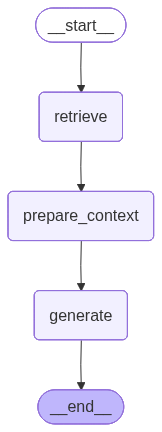

🚀 Iniciando procesamiento RAG con LangGraph
🔍 Ejecutando nodo: retrieve_documents
📝 Ejecutando nodo: prepare_context
🤖 Ejecutando nodo: generate_response
✅ Procesamiento completado

✅ RESULTADO FINAL:
🤖 Respuesta: Los métodos HTTP son GET, POST, PUT, PATCH y DELETE. Cada uno tiene un propósito específico, como obtener, crear, actualizar o eliminar recursos.
📄 Fuentes utilizadas: api_development_standards.md, api_development_standards.md, api_development_standards.md
📊 Documentos procesados: 3


In [15]:
# Pregunta de prueba
question = "Cuáles son los métodos HTTP?"

# Ejecución del flujo crado 
result = ask_rag_langgraph(
    question = question,
    vector_store = vector_store,
    k = 3,
    search_type = "similarity"
)

# Visualización de los resultados
print("\n✅ RESULTADO FINAL:")
print(f"🤖 Respuesta: {result['answer']}")
print(f"📄 Fuentes utilizadas: {', '.join(result['sources'])}")
print(f"📊 Documentos procesados: {len(result['context'])}")

# LAB AGENTES - PARTE 2

## Añadiendo memoria conversacional

In [17]:
from langgraph.graph.message import add_messages
from typing import Annotated

class MemoryRAGState(TypedDict):
    
        """
    Estado RAG expandido con memoria conversacional
    
    Añade capacidades de memoria al estado original:
    - conversation_history: Historial automático de mensajes
    - session_id: Identificador de conversación
    - user_context: Información personal extraída automáticamente
    
    NOTA: El vector_store no se incluye para evitar problemas de serialización
    """
      
    # Campos originales del RAG
        question: str
        k: int
        retrieved_docs: List[Document]
        context_text: str
        answer: str
        sources: List[str]
        processing_metadata: Dict[str, Any]

        # Campos nuevos para manejo de memoria conversacional
        conversation_history: Annotated[List[Dict[str, Any]], add_messages]
        session_id: str
        user_context: Dict[str, Any]

In [18]:
from langgraph.checkpoint.sqlite import SqliteSaver
import sqlite3

def create_memory_checkpointer(db_path: str = "langgraph_memory.db"):
    
        """
    Crea checkpointer SQLite para memoria persistente automática
    
    LangGraph manejará automáticamente:
    - Guardado de estado después de cada nodo
    - Recuperación de estado por session_id
    - Persistencia entre sesiones
    """
    
        # Creación de la conexión con la base de datos
        conn = sqlite3.connect(db_path, check_same_thread = False)
        return SqliteSaver(conn)

# Crear checkpointer global
memory_checkpointer = create_memory_checkpointer()

# Variable global para vector_store (no serializable)
global_vector_store = None

In [19]:
conversational_memory_prompt = ChatPromptTemplate.from_template("""
        Eres un asistente especializado en responder preguntas sobre documentación técnica de desarrollo de software. 

        IMPORTANTE: Mantén la continuidad conversacional usando el historial de conversación proporcionado.

        {conversation_history}

        Utiliza únicamente la información del contexto proporcionado para responder la pregunta actual. 
        Si no conoces la respuesta basándote en el contexto, indica claramente que no tienes esa información.

        Si el usuario se ha presentado o ha proporcionado información personal en conversaciones anteriores, úsala para personalizar tu respuesta cuando sea apropiado.

        Mantén las respuestas concisas, precisas y usa máximo tres oraciones.

        Pregunta actual: {question}

        Contexto de documentación: {context}

        Respuesta:
        """)

## Uso de la memoria para personalizar recuperación y generación


In [21]:
def extract_user_context_comprehensive(history):
    
        """
    Extrae información personal de usuario a partir del historial
        de conversación. Útil para personalizar las respuestas del modelo. 
    """
    
        # Estructura par manejar la inforamción contextual del usuario
        user_context = {
                # Lista de todos los mensajes con información personal 
                "personal_info_messages": [], 
                # Mensaje más reciente con información personal 
                "latest_personal_info": "",    
                # Información personal consolidada
                "consolidated_info": ""        
        }

        # Lista de palabras que suelen denotar el inicio de información asociada con el usuario
        # Se puede ampliar
        personal_keywords = ["soy", "me llamo", "trabajo",
                                                "especializo", "estudió", "vivo en", "tengo experiencia", 
                                                "mi nombre", "trabajo como", "me dedico"]

        # Revisión de los mensajes en el historial 
        for msg in history:
                content = ""
                if hasattr(msg, 'type') and msg.type == "human":
                        content = msg.content
                elif hasattr(msg, 'get') and msg.get("role") == "user":  
                        content = msg.get("content", "")
                
                # Revisión de información personal en el mesaje
                if content and any(word in content.lower() for word in personal_keywords):
                        user_context["personal_info_messages"].append(content)
                        user_context["latest_personal_info"] = content  

        # Consolidación de toda la información personal 
        if user_context["personal_info_messages"]:
                user_context["consolidated_info"] = " | ".join(user_context["personal_info_messages"])

        return user_context

In [22]:
def memory_retrieve_documents(state: MemoryRAGState) -> MemoryRAGState:
    
        """
    Nodo de recuperación que usa contexto conversacional.
    Maneja la información personal del usuario y el proceso clásico de
    recuperación de información. 
    """

        # Obtención de información almacenada en el contexto
        question = state["question"]
        vector_store = global_vector_store
        history = state.get("conversation_history", [])

        # Extracción de información personal del usuario a partir del historial de mensajes
        user_context = extract_user_context_comprehensive(history)

        # Si hay historial, se utiliza para mejorar el contexto
        if history:
                recent_questions = []
                # Revisa los últimos dos mensajes del usuario
                for msg in history[-2:]: 
                        if hasattr(msg, 'type') and msg.type == "human":
                                recent_questions.append(msg.content)
                        elif hasattr(msg, 'get') and msg.get("role") == "user":  
                                recent_questions.append(msg.get("content", ""))
                
                # Se agregan los ultimos dos mensaje al contexto, ademas de la pregunta
                enhanced_query = f"{question} [Contexto: {' | '.join(recent_questions)}]"
        else:
                enhanced_query = question

        # Recuperación de documentos
        retrieved_docs = vector_store.similarity_search(enhanced_query, k = state.get("k", 3))

        new_user_message = {"role": "user", "content": question}
        updated_history = history + [new_user_message]

        return {
                **state,
                "retrieved_docs": retrieved_docs,
                "user_context": user_context,
                "conversation_history": updated_history,
                "processing_metadata": {
                        **state.get("processing_metadata", {}),
                        "used_conversation_context": len(history) > 0,
                        "enhanced_query": enhanced_query,
                        "personal_info_count": len(user_context["personal_info_messages"])
                }
        }

In [23]:
def memory_prepare_context(state: MemoryRAGState) -> MemoryRAGState:
    
        """
    Nodo que prepara contexto y extrae información del usuario del historial.
    Se encarga de preparar todo el contexto necesario para la generación 
    de respuestas. 
    """
      
        print("📝 Ejecutando nodo: prepare_context")

        # Obtención de información almacenada en el estado compartido
        retrieved_docs = state["retrieved_docs"]
        history = state.get("conversation_history", [])

        # Prepara el contexto concatenando el contenido 
        context_text = "\n\n".join(doc.page_content for doc in retrieved_docs)

        # Extrae las fuentes asociadas con el contexto
        sources = [doc.metadata.get('source_file', 'unknown') for doc in retrieved_docs]

        # Obtiene el contexto personal del usuario
        user_context = extract_user_context_comprehensive(history)

        return {
                **state,
                "context_text": context_text,
                "sources": sources,
                "user_context": user_context,
                "processing_metadata": {
                        **state.get("processing_metadata", {}),
                        "context_length": len(context_text),
                        "sources_count": len(set(sources)),
                        "total_personal_messages": len(user_context["personal_info_messages"])
                }
        }

In [24]:
def memory_generate_response(state: MemoryRAGState) -> MemoryRAGState:
    
        """
    Nodo de generación personalizada con memoria.
    Se incorpora toda la incorporación recuperada en el prompt para que 
        el modelo la entienda y la tenga en cuenta. 
    """
    
        # Obtención de la información almacenada en el estado compartido 
        question = state["question"]
        context_text = state["context_text"]
        history = state.get("conversation_history", [])
        user_context = state.get("user_context", {})

        # Formateo del historial de la conversación manejando objetos nativos de LangChain
        conversation_history = ""
        if history:
                conversation_history = "HISTORIAL DE CONVERSACIÓN:\n"
                for i, msg in enumerate(history, 1):
                        if hasattr(msg, 'type'):  
                                role = "Usuario" if msg.type == "human" else "Asistente"
                                content = msg.content
                        else:  
                                role = "Usuario" if msg.get("role") == "user" else "Asistente"
                                content = msg.get("content", "")
                        # Se añade el contenido recuperado al historial 
                        conversation_history += f"{i}. {role}: {content}\n"

                conversation_history += "\n"
                
                # Añade la información personal del usuario si se encuentra disponible
                if user_context.get("consolidated_info"):
                        conversation_history += f"INFORMACIÓN PERSONAL DEL USUARIO: {user_context['consolidated_info']}\n\n"
        
        else:
                conversation_history = "Esta es la primera pregunta de la conversación.\n\n"

        # Usa el prompt definido anteriormente para recopilar toda la información
        messages = conversational_memory_prompt.invoke({
                "conversation_history": conversation_history,
                "question": question,
                "context": context_text
        })

        # Generación de la respuesta
        response = llm.invoke(messages)
        new_assistant_message = {"role": "assistant", "content": response.content}
        updated_history = history + [new_assistant_message]

        return {
                **state,
                "answer": response.content,
                "conversation_history": updated_history,
                "processing_metadata": {
                        **state.get("processing_metadata", {}),
                        "used_formatted_history": len(history) > 0,
                        "used_personal_context": bool(user_context.get("consolidated_info"))
                }
        }

## Construcción del grafo con memoria conversacional


In [25]:
def create_memory_rag_graph():
    """
    Crea grafo LangGraph con memoria conversacional automática
    
    Ventajas sobre implementación manual:
    - LangGraph maneja automáticamente el estado entre nodos
    - Checkpointer persiste todo automáticamente
    - Recuperación de estado por session_id
    - Rollback y debugging built-in
    """
    
    workflow = StateGraph(MemoryRAGState)
    
    # Añadir nodos con memoria
    workflow.add_node("retrieve", memory_retrieve_documents)
    workflow.add_node("prepare_context", memory_prepare_context)
    workflow.add_node("generate", memory_generate_response)
    
    # Flujo sin cambios
    workflow.add_edge(START, "retrieve")
    workflow.add_edge("retrieve", "prepare_context")
    workflow.add_edge("prepare_context", "generate")
    workflow.add_edge("generate", END)
    
    # Compilar con checkpointer para manejo automático de sesión 
    return workflow.compile(checkpointer = memory_checkpointer)

In [26]:
memory_app = create_memory_rag_graph()

## Ejecución, pruebas e inspección del asistente


In [27]:
def ask_rag_with_langgraph_memory(question: str, vector_store, session_id: str = None, k: int = 3):
    
        """
    RAG con memoria usando LangGraph
    
    ¿Qué hace LangGraph automáticamente?
    - Persiste el estado después de cada nodo
    - Recupera historial por session_id
    - Maneja la memoria conversacional
    - Permite debugging paso a paso
    """
    
        # Establece el vector store como variable global para evitar errores de serialización
        global global_vector_store
        global_vector_store = vector_store  

        # Crea un id de sesión si uno no es pasado como parámetro
        if not session_id:
                import uuid
                session_id = str(uuid.uuid4())[:8]

        # Estado inicial (SIN vector_store para evitar error de serialización)
        initial_state = {
                "question": question,
                "k": k,
                "retrieved_docs": [],
                "context_text": "",
                "answer": "",
                "sources": [],
                "conversation_history": [],  
                "session_id": session_id,
                "user_context": {},
                "processing_metadata": {}
        }

        # Configuración para checkpointer
        config = {"configurable": {"thread_id": session_id}}

        final_state = memory_app.invoke(initial_state, config = config)

        return {
                "question": final_state["question"],
                "answer": final_state["answer"],
                "sources": [doc.metadata.get('source_file', 'unknown') for doc in final_state["retrieved_docs"]],
                "session_id": session_id,
                "used_memory": final_state["processing_metadata"].get("used_conversation_context", False),
                "formatted_history": final_state["processing_metadata"].get("used_formatted_history", False)
        }

In [28]:
import uuid

def new_conversation():
    
        """
    Crea una nueva sesión de conversación.
    Establece el id para la sesión
    """
    
        return str(uuid.uuid4())[:8]

In [29]:
def continue_chat(question, vector_store, session_id):
    
        """
    Continua una conversación existente haciendo uso del id de la sesión. 
    """
    
        result = ask_rag_with_langgraph_memory(question, vector_store, session_id)
        print(f"👤 Usuario: {question}")
        print(f"🤖 {result['answer']}")
        return result

In [30]:
def quick_test():
    
        """
    Test simulado para verificar el correcto funcionamiento del flujo.
    """
      
        session = new_conversation()
        print(f"🆕 Nueva sesión creada: {session}")
        print("Test 1:")
        continue_chat("Soy Ana, desarrolladora React", vector_store, session)
        print("\nTest 2:")
        continue_chat("¿Qué frameworks React recomiendas para alguien como yo?", vector_store, session)
        print("\nTest 3:")
        continue_chat("¿Qué son las APIs REST?", vector_store, session)
        print("\nTest 4:")
        continue_chat("¿Qué pasa cuando tengo Alta latencia en respuestas de API?", vector_store, session)
        print("\nTest 5:")
        continue_chat("¿Recuerdas mi nombre?", vector_store, session)
        return session

In [31]:
example_id = quick_test()

🆕 Nueva sesión creada: a5a32924
Test 1:
📝 Ejecutando nodo: prepare_context
👤 Usuario: Soy Ana, desarrolladora React
🤖 

Test 2:
📝 Ejecutando nodo: prepare_context
👤 Usuario: ¿Qué frameworks React recomiendas para alguien como yo?
🤖 

Test 3:
📝 Ejecutando nodo: prepare_context
👤 Usuario: ¿Qué son las APIs REST?
🤖 

Test 4:
📝 Ejecutando nodo: prepare_context
👤 Usuario: ¿Qué pasa cuando tengo Alta latencia en respuestas de API?
🤖 Hola Ana, cuando tienes alta latencia en respuestas de API, los síntomas incluyen tiempos de respuesta superiores a 2 segundos y timeouts frecuentes. Esto puede llevar a quejas de los usuarios sobre la lentitud de la aplicación.

Test 5:
📝 Ejecutando nodo: prepare_context
👤 Usuario: ¿Recuerdas mi nombre?
🤖 Sí, Ana, recuerdo que te llamas Ana.


In [32]:
import traceback

def inspect_langgraph_state(session_id: str):

        """
    Inspecciona el estado guardado por LangGraph
    Útil para conocer la configuración guardada en el estado compartido y ver el proceso 
    paso a paso.
    """
    
        config = {"configurable": {"thread_id": session_id}}

        try:
                # Obtener estado actual del checkpointer
                state_snapshot = memory_app.get_state(config)
                
                if state_snapshot.values:
                        history = state_snapshot.values.get("conversation_history", [])
                        user_context = state_snapshot.values.get("user_context", {})
                        
                        # Informacón básica presente en el estado
                        print(f"\n🔍 ESTADO DE SESIÓN: {session_id}")
                        print("=" * 50)
                        print(f"💬 Mensajes en historial: {len(history)}")
                        print(f"👤 Contexto de usuario: {user_context.get('consolidated_info', 'Sin información personal')}")
                        print(f"🏷️ Último checkpoint: {state_snapshot.config}")
                        
                        # Extracción del historial de mensajes, en caso de que exista
                        if history:
                                print(f"\n📖 Últimos {min(3, len(history))} mensajes:")
                                print("-" * 40)
                                
                                for i, msg in enumerate(history[-3:], len(history)-2 if len(history) > 3 else 1):
                                        if hasattr(msg, 'type'):  # It's a LangChain message object
                                                role = "👤 Usuario" if msg.type == "human" else "🤖 Asistente"
                                                content = msg.content
                                        else:  
                                                role = "👤 Usuario" if msg.get("role") == "user" else "🤖 Asistente"
                                                content = msg.get("content", "")
                                        
                                        display_content = content[:80] + "..." if len(content) > 80 else content
                                        print(f"{i:2d}. {role}: {display_content}")
                                
                                # Estadísticas adicionales
                                print(f"\n📊 ESTADÍSTICAS:")
                                print(f"   🗨️  Total conversaciones: {len(history)}")
                                
                                # Conteo de mensajes según rol
                                user_msgs = 0
                                assistant_msgs = 0
                                for msg in history:
                                        if hasattr(msg, 'type'):
                                                if msg.type == "human":
                                                        user_msgs += 1
                                                else:
                                                        assistant_msgs += 1
                                        else:
                                                if msg.get("role") == "user":
                                                        user_msgs += 1
                                                else:
                                                        assistant_msgs += 1
                                
                                print(f"   👤 Mensajes de usuario: {user_msgs}")
                                print(f"   🤖 Respuestas del asistente: {assistant_msgs}")
                                
                                # Visualización de información personal
                                if user_context.get('personal_info_messages'):
                                        print(f"   📋 Info personal recopilada: {len(user_context['personal_info_messages'])} mensaje(s)")
                                        print(f"   📝 Última info personal: {user_context.get('latest_personal_info', 'N/A')[:50]}...")
                                
                        else:
                                print("\n📭 No hay mensajes en el historial")
                                
                else:
                        print(f"⚠️ No se encontró estado para sesión: {session_id}")
                        
        except Exception as e:
                print(f"❌ Error inspeccionando estado: {e}")
                print(f"🔧 Detalles del error:\n{traceback.format_exc()}")

In [33]:
inspect_langgraph_state(session_id = example_id)


🔍 ESTADO DE SESIÓN: a5a32924
💬 Mensajes en historial: 10
👤 Contexto de usuario: Soy Ana, desarrolladora React | ¿Recuerdas mi nombre?
🏷️ Último checkpoint: {'configurable': {'thread_id': 'a5a32924', 'checkpoint_ns': '', 'checkpoint_id': '1f0c1013-61c6-6b01-8017-96a20bd766e9'}}

📖 Últimos 3 mensajes:
----------------------------------------
 8. 🤖 Asistente: Hola Ana, cuando tienes alta latencia en respuestas de API, los síntomas incluye...
 9. 👤 Usuario: ¿Recuerdas mi nombre?
10. 🤖 Asistente: Sí, Ana, recuerdo que te llamas Ana.

📊 ESTADÍSTICAS:
   🗨️  Total conversaciones: 10
   👤 Mensajes de usuario: 5
   🤖 Respuestas del asistente: 5
   📋 Info personal recopilada: 2 mensaje(s)
   📝 Última info personal: ¿Recuerdas mi nombre?...


# LAB AGENTES - PARTE 3

## Añadiendo búsquedas en internet para respuestas actualizadas

In [34]:
# Crear checkpointer global
memory_checkpointer = create_memory_checkpointer(db_path = "langgraph_memory_with_search.db")

# Variable global para vector_store (no serializable)
global_vector_store = None

## Actualización del prompt y nuevos nodos

In [35]:
def should_search_web(state: MemoryRAGState) -> dict:
    
        """
    Nodo condicional que habilita un flujo human-in-the-loop.

    Pregunta al usuario si desea realizar una búsqueda en internet para
    complementar la respuesta. La decisión bifurca el grafo en dos ramas:
    'yes' continúa hacia la búsqueda web; 'no' salta directamente a la generación
    de respuesta con el contexto ya disponible.

    La respuesta se incorpora al estado con la clave 'web_search', que se usa como
    condición de control para el flujo en LangGraph.

    Parámetros:
    - state (MemoryRAGState): Estado actual del sistema, que incluye la pregunta del usuario.

    Retorna:
    - dict: Estado extendido con la clave 'web_search' y el valor 'yes' o 'no',
      dependiendo de la decisión del usuario.
    """
    
        question = state["question"]
        user_input = input(f"🌐 ¿Buscar en internet para: '{question}'? (s/n): ")
        decision = "yes" if user_input.lower() in ["s", "si", "sí", "y", "yes"] else "no"

        # La clave debe coincidir con las ramas de decisión en el grafo
        return {"web_search": decision, **state}

In [36]:
from langchain_core.documents import Document  
from ddgs import DDGS

def web_search_documents(state: MemoryRAGState) -> MemoryRAGState:
        
        """
    Nodo opcional del grafo que realiza una búsqueda en la web para enriquecer el contexto.

    Utiliza el motor DuckDuckGo (`ddgs`) para obtener hasta tres resultados relevantes
    en español relacionados con la pregunta actual. Cada resultado se convierte en un 
    documento estructurado que se añade a la lista `retrieved_docs` del estado.

    Esto permite complementar la información recuperada de la base de datos vectorial
    con contenido actualizado y proveniente de fuentes externas.

    Si ocurre un error durante la búsqueda, el sistema lo registra en consola pero 
    continúa su ejecución sin interrumpir el flujo del grafo.

    Parámetros:
    - state (MemoryRAGState): Estado actual del sistema, que contiene la pregunta del usuario.

    Retorna:
    - MemoryRAGState: El mismo estado, extendido con los nuevos documentos provenientes de la web 
      y metadatos sobre la cantidad de documentos añadidos.
    """

        question = state["question"]
        web_docs = []

        try:
                # Configuración de los parámetros de navegación
                results = DDGS().text(
                        query = question,
                        region = "es-es",  
                        safesearch = "moderate",
                        max_results = 3,
                        backend = "auto"
                )

                # Iteración sobre los resultados para obtener el contenido relevante
                for r in results:
                        title = r.get("title", "Sin título")
                        snippet = r.get("body", "")
                        link = r.get("href", "#")

                        content = f"""🔗 {title} {snippet} 👉 Enlace: {link}"""
                        web_docs.append(Document(page_content = content, metadata = {"source_file": "web_search"}))


        except Exception as e:
                print(f"🌐 Error en búsqueda web: {e}")

        # El contenido obtenido se concatena con el contexto recuperado de la base
        # de datos vectorial
        retrieved_docs = state.get("retrieved_docs", []) + web_docs

        # Se retorna el estado actualizado
        return {
                **state,
                "retrieved_docs": retrieved_docs,
                "processing_metadata": {
                        **state.get("processing_metadata", {}),
                        "web_docs_added": len(web_docs)
                }
        }

In [37]:
def create_memory_rag_graph_with_approval():
    
        """
    Construye y compila un grafo conversacional con memoria y búsqueda web opcional,
    utilizando bifurcación condicional según la decisión del usuario.

    El grafo sigue el siguiente flujo:
    1. Recupera documentos desde la memoria.
    2. Pregunta si se desea realizar una búsqueda en internet.
    3. Si el usuario acepta, busca en la web y añade los resultados al contexto.
    4. Prepara el contexto combinando los documentos recuperados.
    5. Genera una respuesta usando un modelo de lenguaje.
    6. Persiste el estado tras cada paso, permitiendo retomar la conversación más adelante.
    """

        # Inicializa el grafo con el estado que se usará entre nodos
        workflow = StateGraph(MemoryRAGState)

        # Define los nodos que forman el asistente
        workflow.add_node("retrieve", memory_retrieve_documents)     # Recuperar desde la memoria
        workflow.add_node("ask_web_search", should_search_web)       # Preguntar si se desea buscar en la web
        workflow.add_node("web_search", web_search_documents)        # Ejecutar búsqueda web (opcional)
        workflow.add_node("prepare_context", memory_prepare_context) # Preparar contexto combinado
        workflow.add_node("generate", memory_generate_response)      # Generar respuesta final

        # Establece el punto de entrada del grafo
        workflow.set_entry_point("retrieve")

        # Enlace directo del nodo de recuperación al nodo de decisión sobre búsqueda web
        workflow.add_edge("retrieve", "ask_web_search")

        # Añade bifurcación condicional basada en la decisión del usuario
        workflow.add_conditional_edges(
                "ask_web_search",
                lambda state: state["web_search"],  # Accede al valor devuelto por el nodo de decisión
                {
                        "yes": "web_search",           # Si se aprueba, buscar en la web
                        "no": "prepare_context"        # Si no, continuar directo a preparar el contexto
                }
        )

        # Si se buscó en la web, continuar con la preparación del contexto
        workflow.add_edge("web_search", "prepare_context")

        # Desde el contexto, proceder a generar la respuesta
        workflow.add_edge("prepare_context", "generate")

        # Finalizar el flujo una vez generada la respuesta
        workflow.add_edge("generate", END)

        # Compilar el grafo con persistencia activada
        return workflow.compile(checkpointer = memory_checkpointer)

# Crear y compilar la aplicación
memory_app = create_memory_rag_graph_with_approval()

In [38]:
def show_graph():
    
        """
    Muestra el grafo en una celda interactiva. 
        Esta configurada específicamente para notebook jupyter.
    """
    
        app = create_memory_rag_graph_with_approval()
    
        try:
                display(Image(app.get_graph().draw_mermaid_png()))
        except ImportError:
                pass

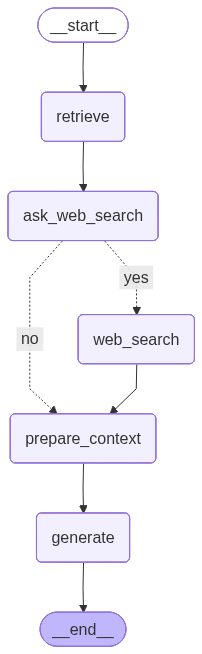

In [39]:
show_graph()

## Probando el asistente con memoria y aprobaciones

In [40]:
def ask_rag_with_langgraph_memory_human_in_loop(question: str, vector_store, session_id: str = None, k: int = 3) -> dict:
    
    """
    Ejecuta el flujo de RAG con memoria y pasos de aprobación (búsqueda web y envío de correo).
    """

    # Establece el vector store como variable global para evitar errores de serialización
    global global_vector_store
    global_vector_store = vector_store

    # Crea un id de sesión si no se proporciona
    if not session_id:
        import uuid
        session_id = str(uuid.uuid4())[:8]

    # Estado inicial para el grafo
    initial_state = {
        "question": question,
        "k": k,
        "retrieved_docs": [],
        "context_text": "",
        "answer": "",
        "sources": [],
        "conversation_history": [],
        "session_id": session_id,
        "user_context": {},
        "processing_metadata": {},
    }

    # Configuración del grafo, se incluye el id de sesión para persistencia automática
    config = {"configurable": {"thread_id": session_id}}

    # Invocación del grafo
    final_state = memory_app.invoke(initial_state, config = config)

        # Se retorna el resultdo de la ejecución junto con información relevante 
    return {
        "question": final_state["question"],
        "answer": final_state["answer"],
        "sources": [doc.metadata.get("source_file", "unknown") for doc in final_state["retrieved_docs"]],
        "session_id": session_id,
        "used_memory": final_state["processing_metadata"].get("used_conversation_context", False),
        "formatted_history": final_state["processing_metadata"].get("used_formatted_history", False)
    }

In [41]:
def continue_chat_with_approval(question, vector_store, session_id):
    
        """
    Ejecuta un turno conversacional usando memoria y búsqueda web si es aprobada.
    """
      
        # Llama al asistente con memoria y decisiones humanas (como búsqueda web)
        result = ask_rag_with_langgraph_memory_human_in_loop(question, vector_store, session_id)

        # Muestra pregunta y respuesta en consola
        print(f"👤 Usuario: {question}")
        print(f"🤖 {result['answer']}")

        return result

In [42]:
def quick_test_with_approval():
    
    session = new_conversation()
    print(f"🆕 Nueva sesión creada: {session}")
    
    print("\nTest 1:")
    continue_chat_with_approval("Soy Ana, desarrolladora React", vector_store, session)

    print("\nTest 2:")
    continue_chat_with_approval("¿Qué es React?", vector_store, session)

    print("\nTest 3:")
    continue_chat_with_approval("¿Qué son las APIs REST?", vector_store, session)

    print("\nTest 4:")
    continue_chat_with_approval("¿Qué pasa cuando tengo alta latencia en respuestas de API?", vector_store, session)

    print("\nTest 5:")
    continue_chat_with_approval("¿Recuerdas mi nombre?", vector_store, session)

    return session

In [46]:
example_id = quick_test_with_approval()

🆕 Nueva sesión creada: 0fa77899

Test 1:
📝 Ejecutando nodo: prepare_context
👤 Usuario: Soy Ana, desarrolladora React
🤖 

Test 2:
📝 Ejecutando nodo: prepare_context
👤 Usuario: ¿Qué es React?
🤖 Ana, según el contexto de documentación proporcionado, no tengo información sobre qué es React. El contexto se centra en estándares de desarrollo de APIs, diseño RESTful y enlaces a foros de coches

Test 3:
📝 Ejecutando nodo: prepare_context
👤 Usuario: ¿Qué son las APIs REST?
🤖 

Test 4:
📝 Ejecutando nodo: prepare_context
👤 Usuario: ¿Qué pasa cuando tengo alta latencia en respuestas de API?
🤖 

Test 5:
📝 Ejecutando nodo: prepare_context
👤 Usuario: ¿Recuerdas mi nombre?
🤖 Sí,


In [47]:
inspect_langgraph_state(example_id)


🔍 ESTADO DE SESIÓN: 0fa77899
💬 Mensajes en historial: 10
👤 Contexto de usuario: Soy Ana, desarrolladora React | ¿Recuerdas mi nombre?
🏷️ Último checkpoint: {'configurable': {'thread_id': '0fa77899', 'checkpoint_ns': '', 'checkpoint_id': '1f0c1023-c1c2-6c43-801f-3cdde7a7ba7f'}}

📖 Últimos 3 mensajes:
----------------------------------------
 8. 🤖 Asistente: 
 9. 👤 Usuario: ¿Recuerdas mi nombre?
10. 🤖 Asistente: Sí,

📊 ESTADÍSTICAS:
   🗨️  Total conversaciones: 10
   👤 Mensajes de usuario: 5
   🤖 Respuestas del asistente: 5
   📋 Info personal recopilada: 2 mensaje(s)
   📝 Última info personal: ¿Recuerdas mi nombre?...
